<a href="https://colab.research.google.com/github/lakshmanpadigala/SMAI_S22_5/blob/main/randomerase_svhn_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
# import matplotlib as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import math
import time

In [2]:
class RandomErasing(object):

    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))
            
            
            
            if w < img.size()[2] and h < img.size()[1]:
                
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
#                     print("Height:",h,"Width:",w)
#                     img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
#                     img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
#                     img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
#                     img[0, x1:x1+h, y1:y1+w] = self.mean[0]
#                     img[1, x1:x1+h, y1:y1+w] = self.mean[1]
#                     img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    # img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [109.9, 109.7, 113.8] ],std=[x / 255.0 for x in [50.1, 50.6, 50.8] ])
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
train_transform.transforms.append(RandomErasing(mean=[x / 255.0 for x in [109.9, 109.7, 113.8] ]))
test_transform = transforms.Compose([transforms.ToTensor(),normalize])

In [5]:
train_dataset = datasets.SVHN(root='data/',
                                  split='train',
                                  transform=train_transform,
                                  download=True)
test_dataset = datasets.SVHN(root='data/',
                                 split='test',
                                 transform=test_transform,
                                 download=True)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [6]:
train_dataset.data.shape, test_dataset.data.shape

((73257, 3, 32, 32), (26032, 3, 32, 32))

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

In [11]:
imgs = []
for i, (images, labels) in enumerate(train_loader):
    imgs.extend(images[0:6])
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

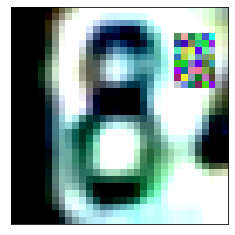

In [12]:
# img_normalized = transform_norm(img)
img_normalized = imgs[5]
  
# convert tis image to numpy array
img_normalized = np.array(img_normalized)
  
# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)
  
# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

In [13]:
num_classes = 10
cnn = ResNet(BasicBlock, [2,2,2,2], num_classes)

In [14]:
cnn.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(6

In [15]:
cnn = cnn.cuda()
criterion = nn.CrossEntropyLoss().cuda()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = MultiStepLR(cnn_optimizer, milestones=[80, 120], gamma=0.1)

In [16]:
def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = cnn(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = correct / total
    cnn.train()
    return val_acc

In [17]:
train_accuracy = []
test_accuracy = []
entropy = []

In [ ]:
for epoch in range(200):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        images = images.cuda()
        labels = labels.cuda()

        cnn.zero_grad()
        pred = cnn(images)

        xentropy_loss = criterion(pred, labels)
        xentropy_loss.backward()
        cnn_optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        # Calculate running average of accuracy
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = correct / total

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    scheduler.step(epoch)  # Use this line for PyTorch <1.4
    # scheduler.step()     # Use this line for PyTorch >=1.4

    # row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    train_accuracy.append(accuracy)
    test_accuracy.append(test_acc)
    entropy.append(xentropy_loss_avg / (i + 1))

In [ ]:
epochs = 200
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(list(range(1,epochs+1)), train_accuracy, label='Training Accuracy')
ax.plot(list(range(1,epochs+1)), test_accuracy, label='Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title("RandomErase_SVHN_random")
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(list(range(1,epochs+1)), entropy, label='Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Value')
ax.set_title("RandomErase_SVHN_random")
ax.legend()
plt.show()

In [ ]:
import pickle
dict_values = {}
dict_values['train_acc'] = train_accuracy
dict_values['test_acc'] = test_accuracy
dict_values['loss'] = entropy

with open('ResNet18_cutOut_SVHN_patch_8.pkl', 'wb') as f:
    pickle.dump(dict_values, f)

# with open('parrot.pkl', 'rb') as f:
#     mynewlist = pickle.load(f)